In [1]:
from scipy.special import logit
from shap.maskers import Independent
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from plots import plot_shap_value_distribution, plot_shap_partial_dependence, plot_shap_values_stacked, \
    plot_shap_values_hierarchically_clustered
import shap
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
shap.initjs()

# Logistic Regression vs XGBoost
Based on ["An introduction to explainable AI with Shapley values" (SHAP documentation)](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html)

## Create Models

In [2]:
X, y = shap.datasets.adult()
feature_names = list(X.columns)
display_data = shap.datasets.adult(display=True)[0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)
X_explain, y_explain, display_data_explain = \
    resample(X, y, display_data, n_samples=500, replace=False, stratify=y, random_state=0)

In [3]:
m1 = LogisticRegression(max_iter=10000)
m1.fit(X_train, y_train)
print(classification_report(m1.predict(X_test), y_test))

              precision    recall  f1-score   support

       False       0.93      0.87      0.90      5293
        True       0.55      0.71      0.62      1220

    accuracy                           0.84      6513
   macro avg       0.74      0.79      0.76      6513
weighted avg       0.86      0.84      0.85      6513



In [4]:
m2 = xgb.XGBClassifier(nestimators=100, max_depth=2)
m2.fit(X_train, y_train)
print(classification_report(m2.predict(X_test), y_test))

[09:53:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { nestimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:53:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

       False       0.95      0.89      0.92      5279
        True       0.63      0.80      0.70      1234

    accuracy                           0.87      6513
   macro avg       0.79      0.84      0.81      6513
weighted avg       0.89      0.87      0.88      6513



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


In [5]:
n_y_pred_different = lambda X: np.sum((m1.predict(X) != m2.predict(X))*1)
print(f'# predictions different in train: {n_y_pred_different(X_train)}/{X_train.shape[0]}')
print(f'# predictions different in test: {n_y_pred_different(X_test)}/{X_test.shape[0]}')
print(f'# predictions different in explain: {n_y_pred_different(X_explain)}/{X_explain.shape[0]}')

# predictions different in train: 1762/26048
# predictions different in test: 442/6513
# predictions different in explain: 36/500


In [6]:
logit_from_log_proba = lambda Y: Y[:,1] - Y[:,0]
f1 = lambda X: logit_from_log_proba(m1.predict_log_proba(X))
c1 = lambda X: m1.predict_proba(X)[:,1]
f2 = lambda X: logit(m2.predict_proba(X)[:,1])
c2 = lambda X: m2.predict_proba(X)[:,1]

In [7]:
complement = lambda p: 1 - p
c1_positive_and_c2_negative = lambda p1, p2: p1 * complement(p2)
c1_negative_and_c2_positive = lambda p1, p2: complement(p1) * p2
c1_and_c2_different = lambda p1, p2: c1_positive_and_c2_negative(p1, p2) + c1_negative_and_c2_positive(p1, p2)

c_c1_positive_and_c2_negative = lambda X: c1_positive_and_c2_negative(c1(X), c2(X))
c_c1_negative_and_c2_positive = lambda X: c1_negative_and_c2_positive(c1(X), c2(X))
c_c1_and_c2_different = lambda X: c1_and_c2_different(c1(X), c2(X))

In [8]:
log_odds_ratio = lambda y1, y2: y1 - y2

f_c1_positive_and_c2_negative = lambda X: logit(c_c1_positive_and_c2_negative(X))
f_c1_negative_and_c2_positive = lambda X: logit(c_c1_negative_and_c2_positive(X))
f_c1_and_c2_different = lambda X: logit(c_c1_and_c2_different(X))
f_log_odds_ratio = lambda X: log_odds_ratio(f1(X), f2(X))

## Generate Explanations

In [9]:
def make_shap_values(model, background_data, feature_names):
    masker = Independent(background_data)
    explainer = shap.Explainer(model, masker, feature_names=feature_names)
    shap_values = explainer(X)
    return shap_values

shap_values_f1 = make_shap_values(f1, X, feature_names)
shap_values_f2 = make_shap_values(f2, X, feature_names)
shap_values_c1 = make_shap_values(c1, X, feature_names)
shap_values_c2 = make_shap_values(c2, X, feature_names)

Permutation explainer: 501it [00:25, 12.36it/s]                         
Permutation explainer: 501it [00:16, 12.00it/s]                         
Permutation explainer: 501it [00:15, 11.73it/s]                         
Permutation explainer: 501it [00:18, 10.53it/s]                         


In [10]:
shap_values_c_c1_positive_and_c2_negative = make_shap_values(c_c1_positive_and_c2_negative, X, feature_names)
shap_values_c_c1_negative_and_c2_positive = make_shap_values(c_c1_negative_and_c2_positive, X, feature_names)
shap_values_c_c1_and_c2_different = make_shap_values(c_c1_and_c2_different, X, feature_names)
shap_values_f_c1_positive_and_c2_negative = make_shap_values(f_c1_positive_and_c2_negative, X, feature_names)
shap_values_f_c1_negative_and_c2_positive = make_shap_values(f_c1_negative_and_c2_positive, X, feature_names)
shap_values_f_c1_and_c2_different = make_shap_values(f_c1_and_c2_different, X, feature_names)
shap_values_f_log_odds_ratio = make_shap_values(f_log_odds_ratio, X, feature_names)

Permutation explainer: 501it [00:37,  9.78it/s]                         
Permutation explainer: 501it [00:43,  8.38it/s]                         
Permutation explainer: 501it [00:37, 10.34it/s]                         
Permutation explainer: 501it [00:33,  9.75it/s]                         
Permutation explainer: 501it [00:35,  9.61it/s]                         
Permutation explainer: 501it [00:32, 10.51it/s]                         
Permutation explainer: 501it [00:30, 10.50it/s]                         


## Analyze

### SHAP Value Distribution

#### Probability Space

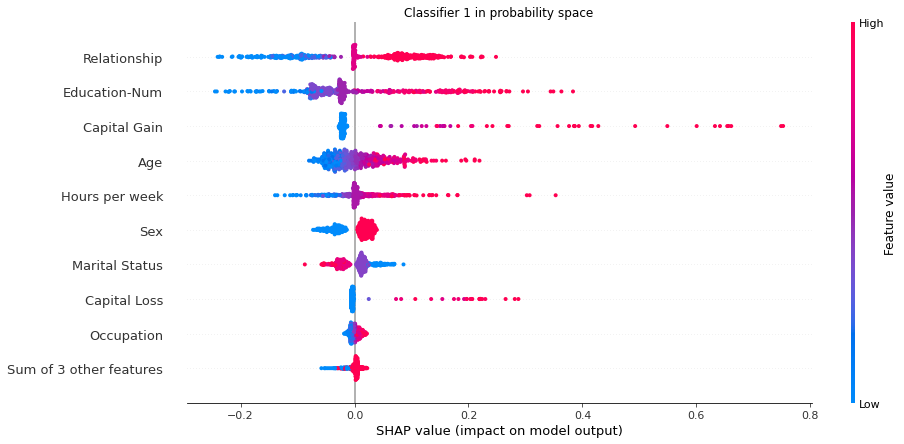

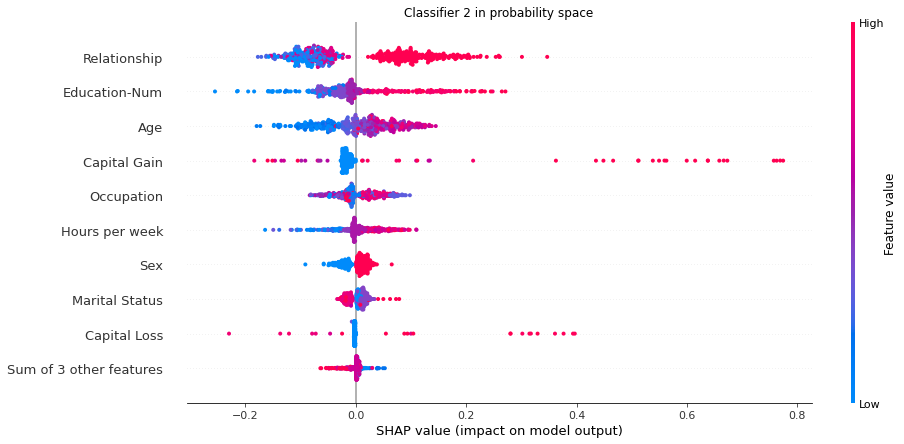

In [11]:
plot_shap_value_distribution(shap_values_c1, 'Classifier 1 in probability space')
plot_shap_value_distribution(shap_values_c2, 'Classifier 2 in probability space')

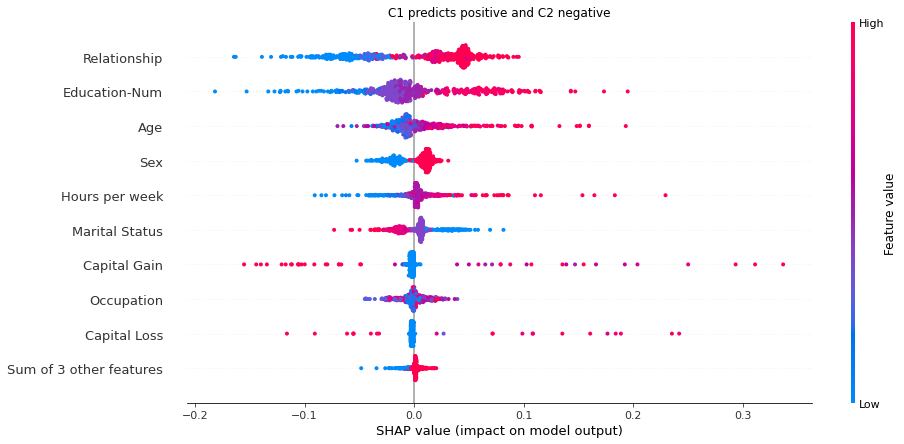

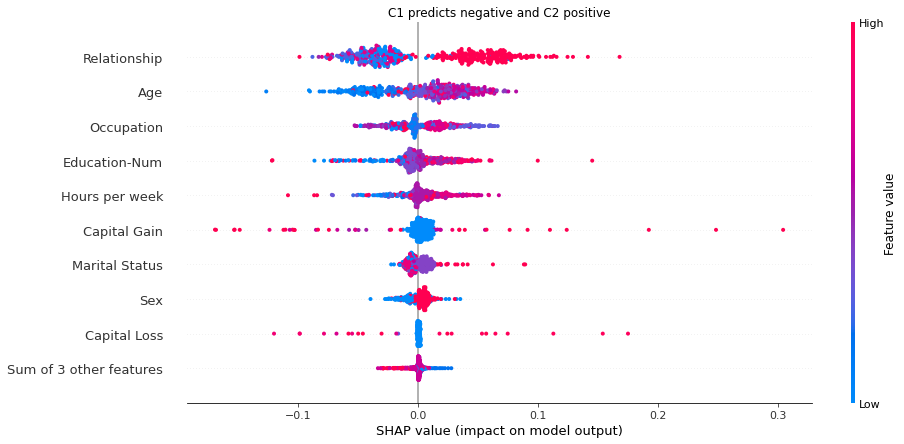

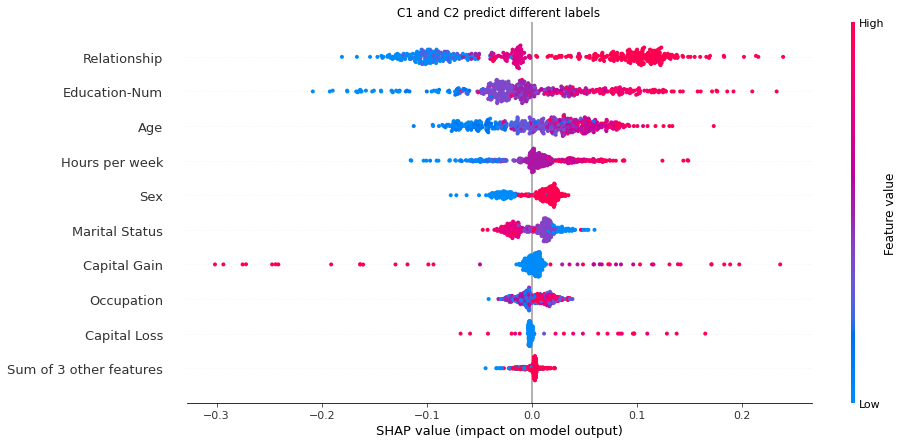

In [12]:
plot_shap_value_distribution(shap_values_c_c1_positive_and_c2_negative, 'C1 predicts positive and C2 negative')
plot_shap_value_distribution(shap_values_c_c1_negative_and_c2_positive, 'C1 predicts negative and C2 positive')
plot_shap_value_distribution(shap_values_c_c1_and_c2_different, 'C1 and C2 predict different labels')

#### Margin Space

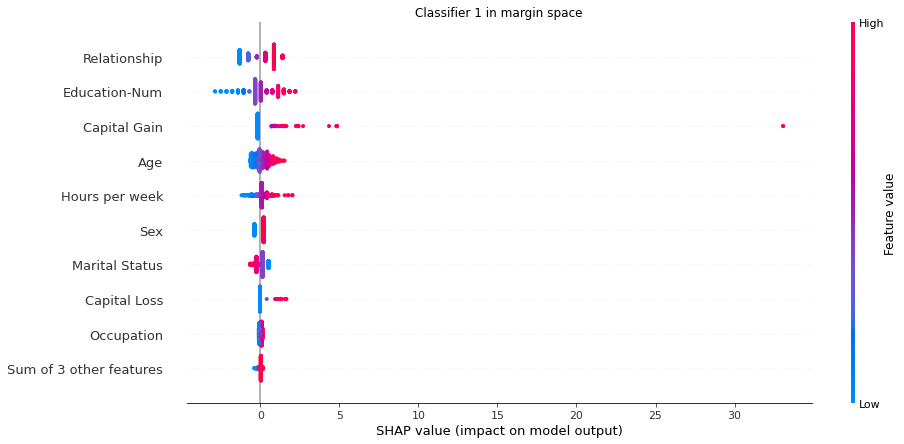

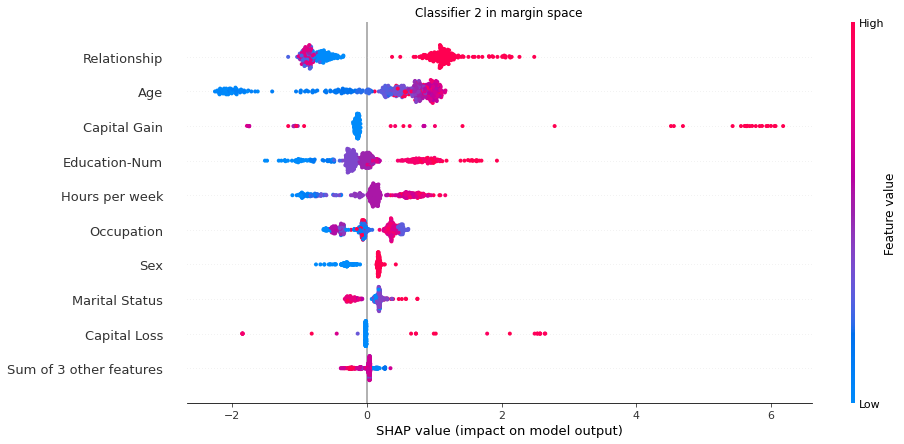

In [13]:
plot_shap_value_distribution(shap_values_f1, 'Classifier 1 in margin space')
plot_shap_value_distribution(shap_values_f2, 'Classifier 2 in margin space')

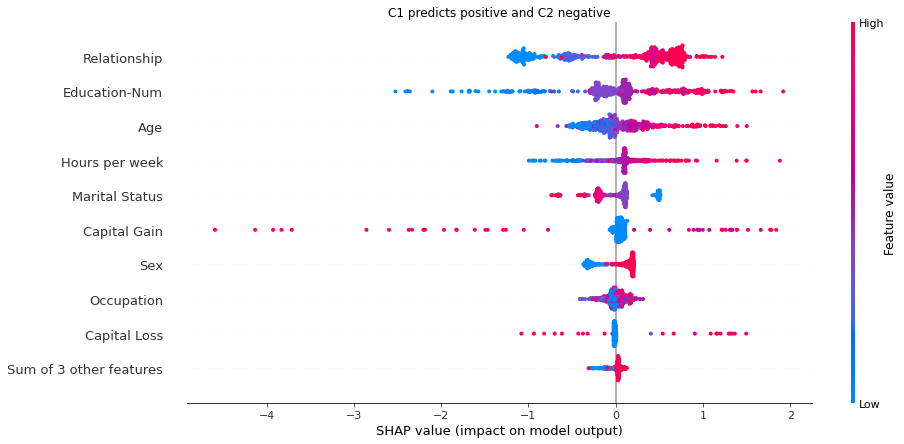

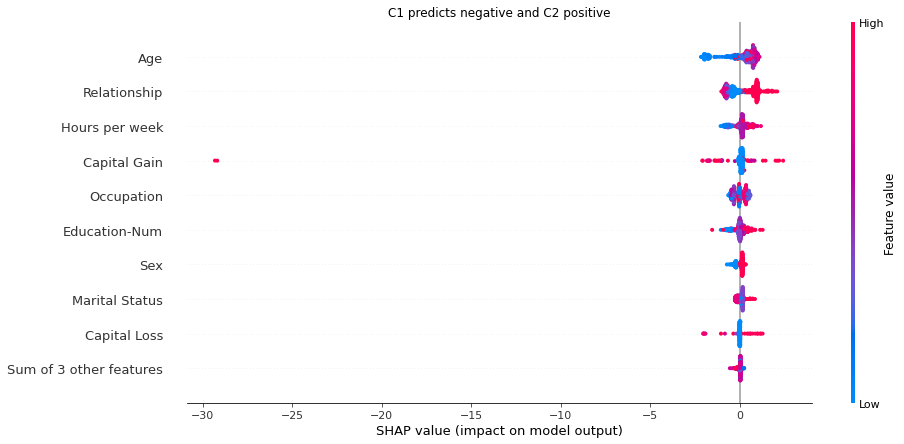

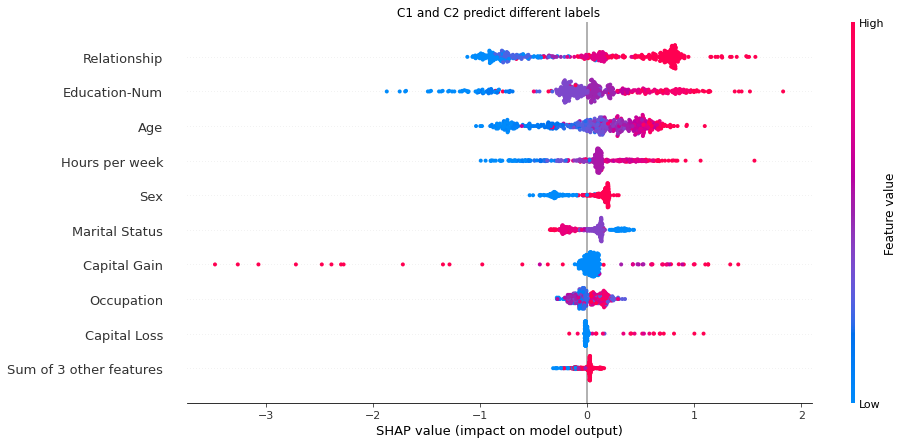

In [14]:
plot_shap_value_distribution(shap_values_f_c1_positive_and_c2_negative, 'C1 predicts positive and C2 negative')
plot_shap_value_distribution(shap_values_f_c1_negative_and_c2_positive, 'C1 predicts negative and C2 positive')
plot_shap_value_distribution(shap_values_f_c1_and_c2_different, 'C1 and C2 predict different labels')

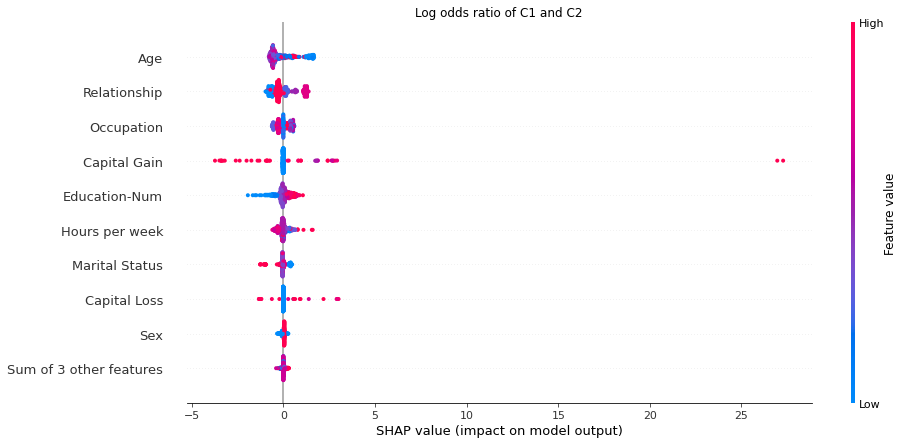

In [15]:
plot_shap_value_distribution(shap_values_f_log_odds_ratio, 'Log odds ratio of C1 and C2')

### Features' Partial Dependence Plots

#### Probability Space

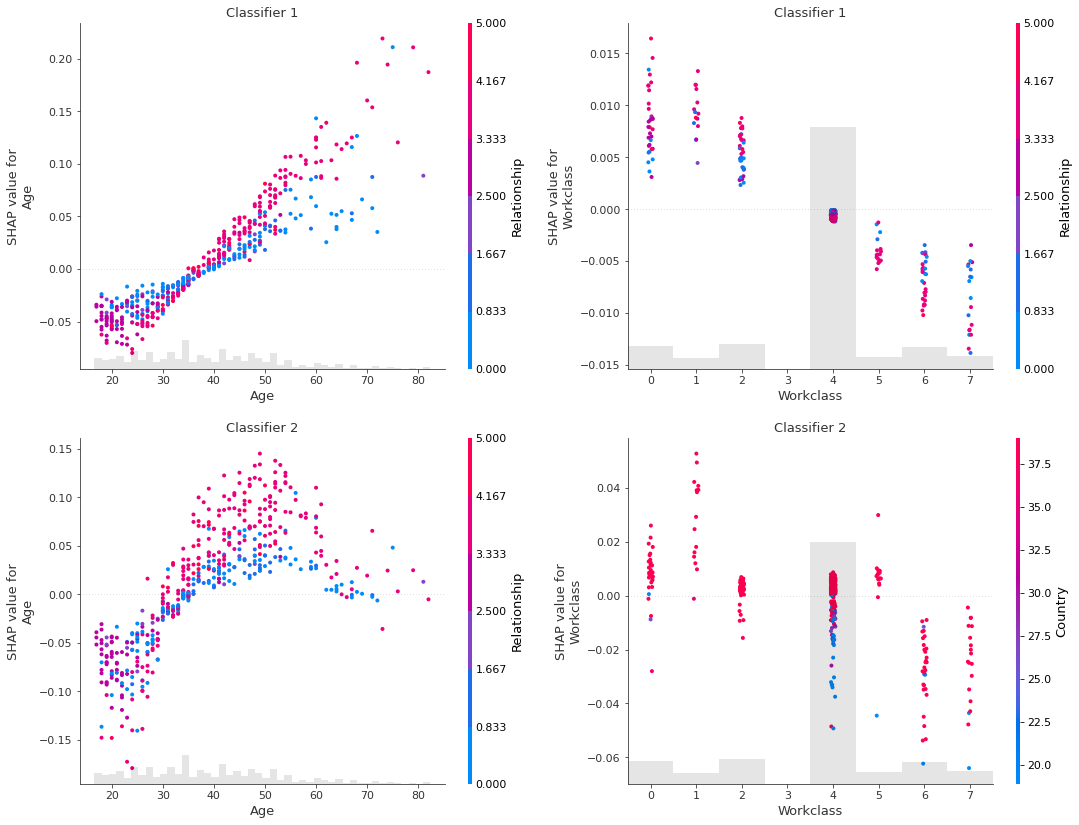

In [16]:
ylim = None
fig, axs = plt.subplots(2, 2, figsize=(18, 14))
plot_shap_partial_dependence(shap_values_c1, feature_names[0], 'Classifier 1', ylim, axs[0,0])
plot_shap_partial_dependence(shap_values_c1, feature_names[1], 'Classifier 1', ylim, axs[0,1])
plot_shap_partial_dependence(shap_values_c2, feature_names[0], 'Classifier 2', ylim, axs[1,0])
plot_shap_partial_dependence(shap_values_c2, feature_names[1], 'Classifier 2', ylim, axs[1,1])
plt.show()

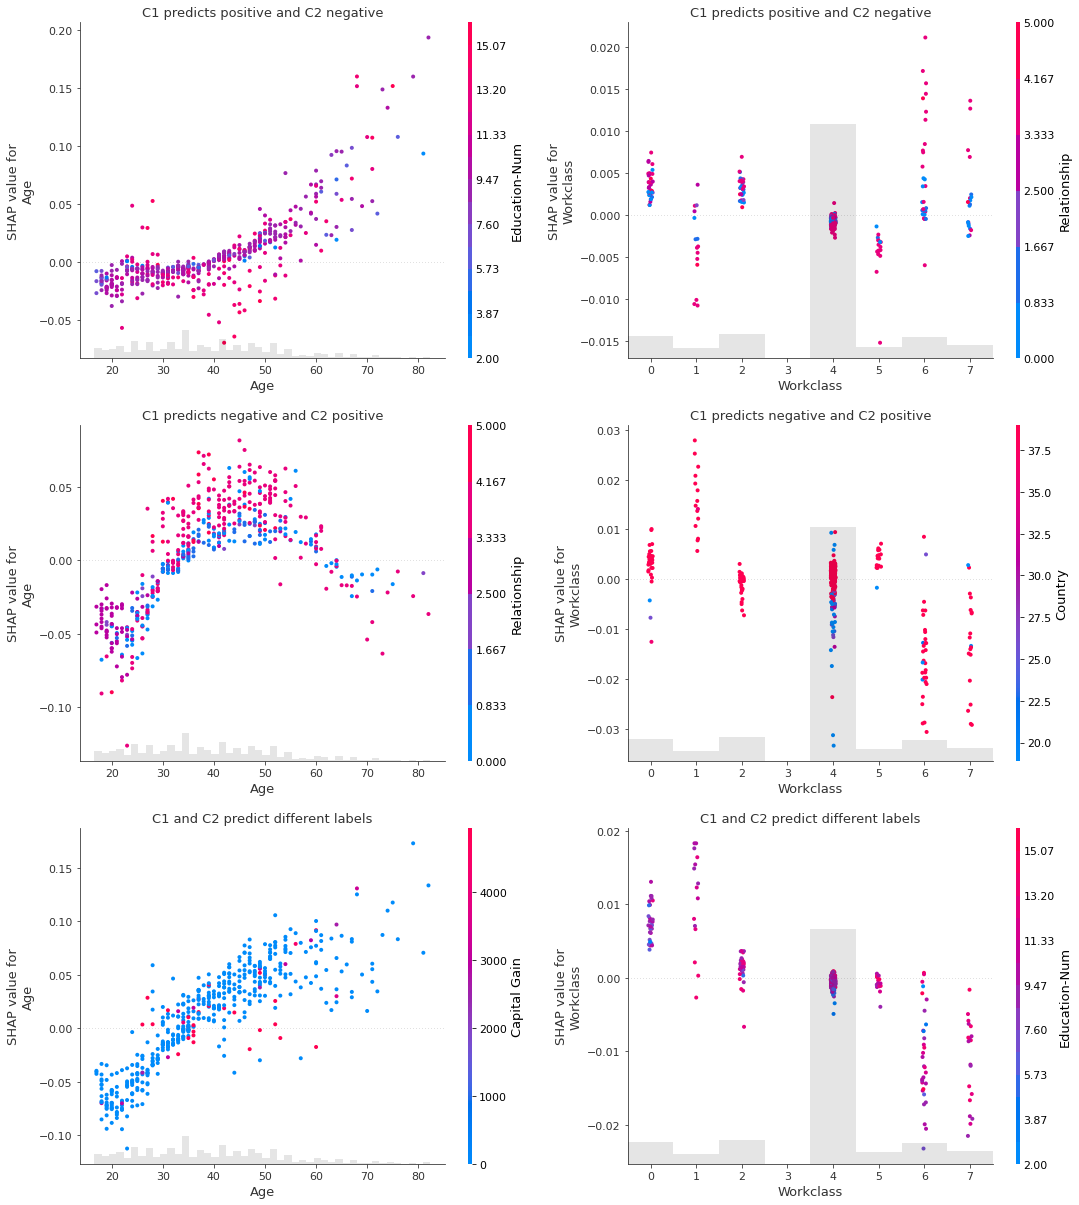

In [17]:
ylim = None
fig, axs = plt.subplots(3, 2, figsize=(18, 21))
plot_shap_partial_dependence(shap_values_c_c1_positive_and_c2_negative, feature_names[0], 'C1 predicts positive and C2 negative', ylim, axs[0,0])
plot_shap_partial_dependence(shap_values_c_c1_positive_and_c2_negative, feature_names[1], 'C1 predicts positive and C2 negative', ylim, axs[0,1])
plot_shap_partial_dependence(shap_values_c_c1_negative_and_c2_positive, feature_names[0], 'C1 predicts negative and C2 positive', ylim, axs[1,0])
plot_shap_partial_dependence(shap_values_c_c1_negative_and_c2_positive, feature_names[1], 'C1 predicts negative and C2 positive', ylim, axs[1,1])
plot_shap_partial_dependence(shap_values_c_c1_and_c2_different, feature_names[0], 'C1 and C2 predict different labels', ylim, axs[2,0])
plot_shap_partial_dependence(shap_values_c_c1_and_c2_different, feature_names[1], 'C1 and C2 predict different labels', ylim, axs[2,1])
plt.show()

#### Margin Space

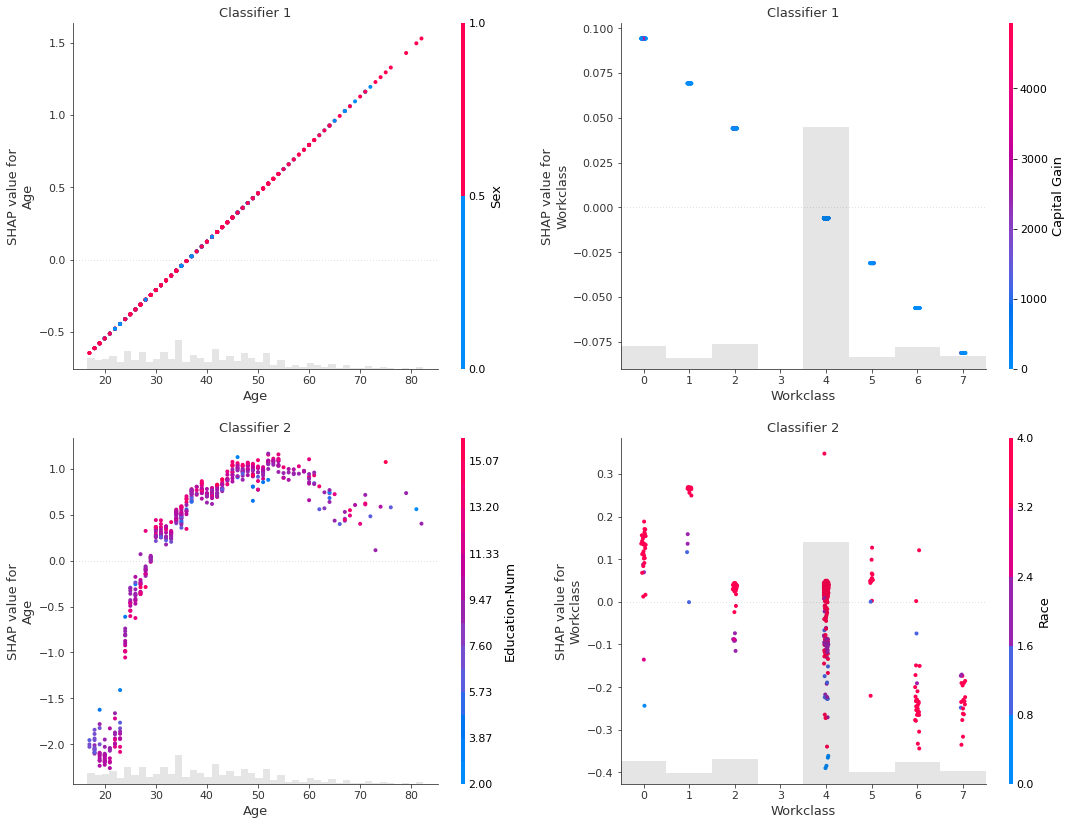

In [18]:
ylim = None
fig, axs = plt.subplots(2, 2, figsize=(18, 14))
plot_shap_partial_dependence(shap_values_f1, feature_names[0], 'Classifier 1', ylim, axs[0,0])
plot_shap_partial_dependence(shap_values_f1, feature_names[1], 'Classifier 1', ylim, axs[0,1])
plot_shap_partial_dependence(shap_values_f2, feature_names[0], 'Classifier 2', ylim, axs[1,0])
plot_shap_partial_dependence(shap_values_f2, feature_names[1], 'Classifier 2', ylim, axs[1,1])
plt.show()

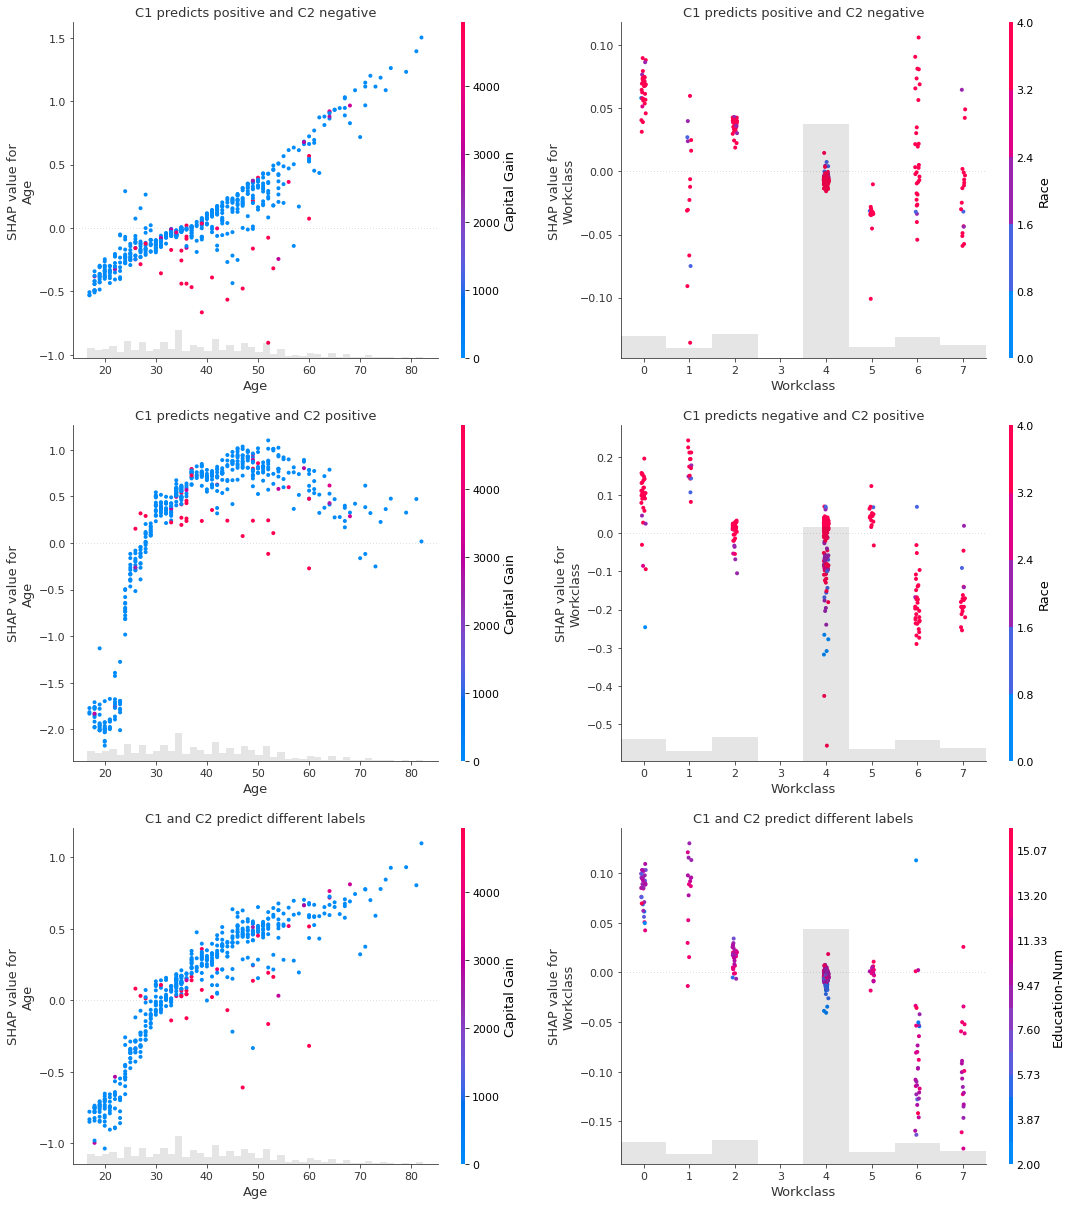

In [19]:
ylim = None
fig, axs = plt.subplots(3, 2, figsize=(18, 21))
plot_shap_partial_dependence(shap_values_f_c1_positive_and_c2_negative, feature_names[0], 'C1 predicts positive and C2 negative', ylim, axs[0,0])
plot_shap_partial_dependence(shap_values_f_c1_positive_and_c2_negative, feature_names[1], 'C1 predicts positive and C2 negative', ylim, axs[0,1])
plot_shap_partial_dependence(shap_values_f_c1_negative_and_c2_positive, feature_names[0], 'C1 predicts negative and C2 positive', ylim, axs[1,0])
plot_shap_partial_dependence(shap_values_f_c1_negative_and_c2_positive, feature_names[1], 'C1 predicts negative and C2 positive', ylim, axs[1,1])
plot_shap_partial_dependence(shap_values_f_c1_and_c2_different, feature_names[0], 'C1 and C2 predict different labels', ylim, axs[2,0])
plot_shap_partial_dependence(shap_values_f_c1_and_c2_different, feature_names[1], 'C1 and C2 predict different labels', ylim, axs[2,1])
plt.show()

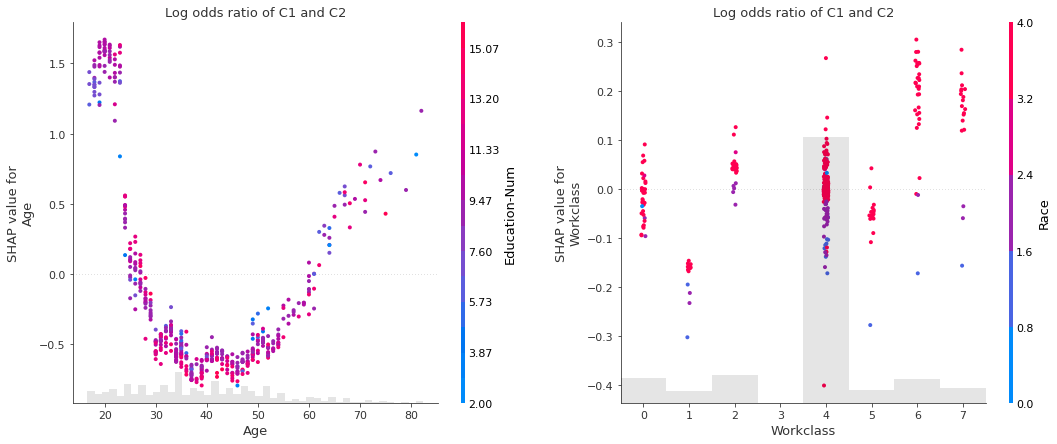

In [20]:
ylim = None
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
plot_shap_partial_dependence(shap_values_f_log_odds_ratio, feature_names[0], 'Log odds ratio of C1 and C2', ylim, axs[0])
plot_shap_partial_dependence(shap_values_f_log_odds_ratio, feature_names[1], 'Log odds ratio of C1 and C2', ylim, axs[1])
plt.show()

### Stacked SHAP Explanations, Clustered by Similarity

#### Probability Space

In [21]:
ordering = plot_shap_values_stacked(shap_values_c1, 'Classifier 1')
plot_shap_values_stacked(shap_values_c2, 'Classifier 2', ordering);

In [22]:
plot_shap_values_stacked(shap_values_c_c1_positive_and_c2_negative, 'C1 predicts positive and C2 negative')
plot_shap_values_stacked(shap_values_c_c1_negative_and_c2_positive, 'C1 predicts negative and C2 positive')
plot_shap_values_stacked(shap_values_c_c1_and_c2_different, 'C1 and C2 predict different labels');

#### Margin Space

In [23]:
ordering = plot_shap_values_stacked(shap_values_f1, 'Classifier 1')
plot_shap_values_stacked(shap_values_f2, 'Classifier 2', ordering);

In [24]:
plot_shap_values_stacked(shap_values_f_c1_positive_and_c2_negative, 'C1 predicts positive and C2 negative')
plot_shap_values_stacked(shap_values_f_c1_negative_and_c2_positive, 'C1 predicts negative and C2 positive')
plot_shap_values_stacked(shap_values_f_c1_and_c2_different, 'C1 and C2 predict different labels');

In [25]:
plot_shap_values_stacked(shap_values_f_log_odds_ratio, 'Log odds ratio of C1 and C2');

### Hierarchically Clustered SHAP Values

#### Probability Space

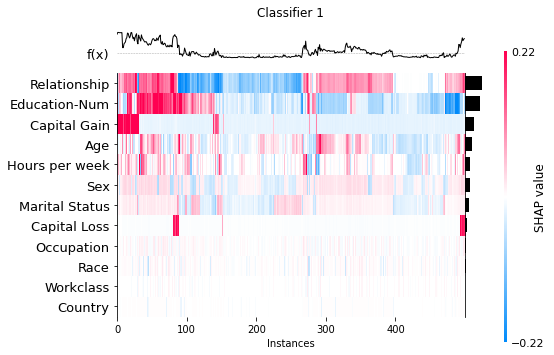

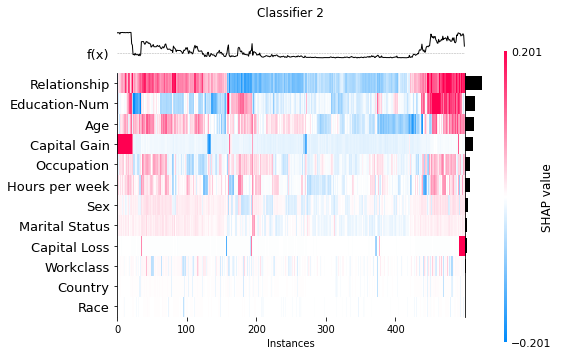

In [26]:
plot_shap_values_hierarchically_clustered(shap_values_c1, 'Classifier 1')
plot_shap_values_hierarchically_clustered(shap_values_c2, 'Classifier 2')

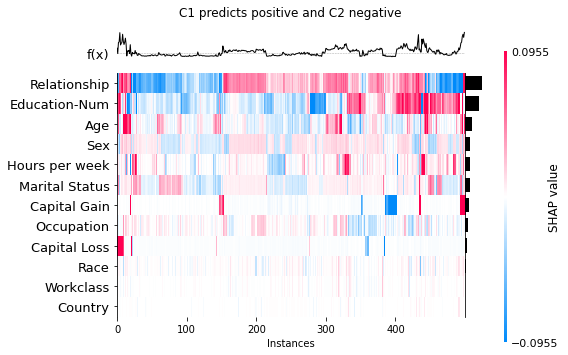

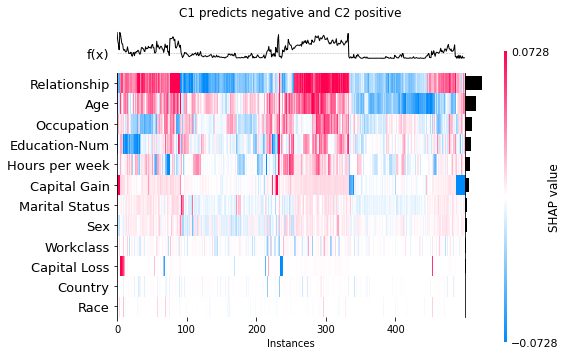

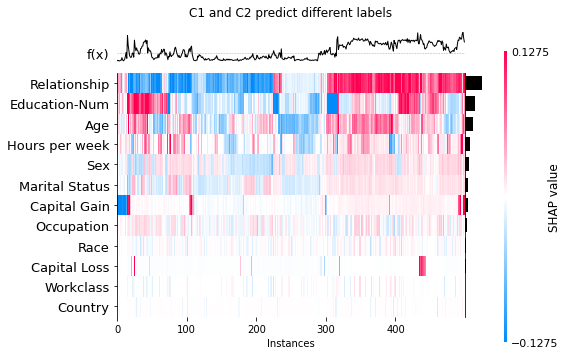

In [27]:
plot_shap_values_hierarchically_clustered(shap_values_c_c1_positive_and_c2_negative, 'C1 predicts positive and C2 negative')
plot_shap_values_hierarchically_clustered(shap_values_c_c1_negative_and_c2_positive, 'C1 predicts negative and C2 positive')
plot_shap_values_hierarchically_clustered(shap_values_c_c1_and_c2_different, 'C1 and C2 predict different labels')

#### Margin Space

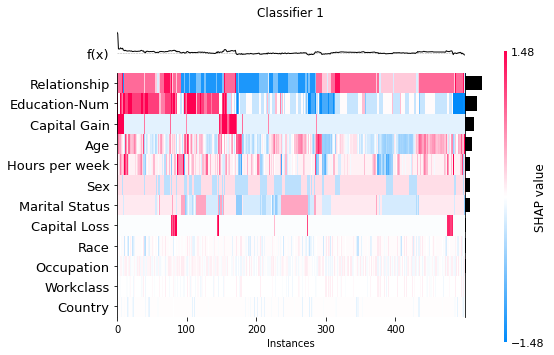

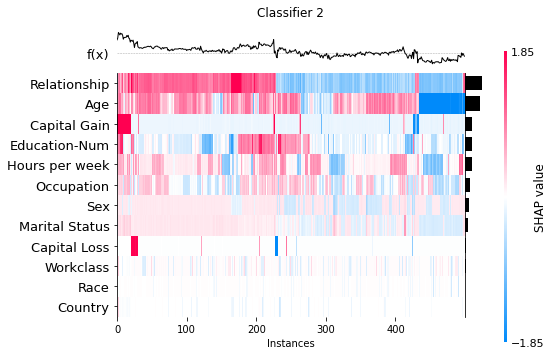

In [28]:
plot_shap_values_hierarchically_clustered(shap_values_f1, 'Classifier 1')
plot_shap_values_hierarchically_clustered(shap_values_f2, 'Classifier 2')

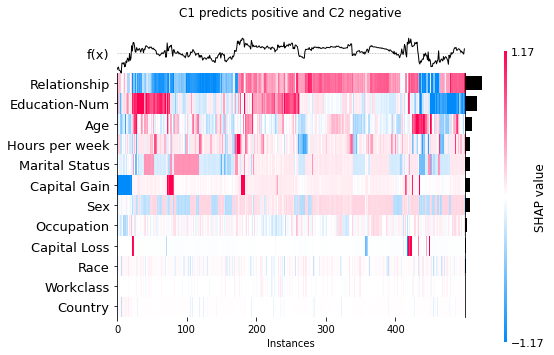

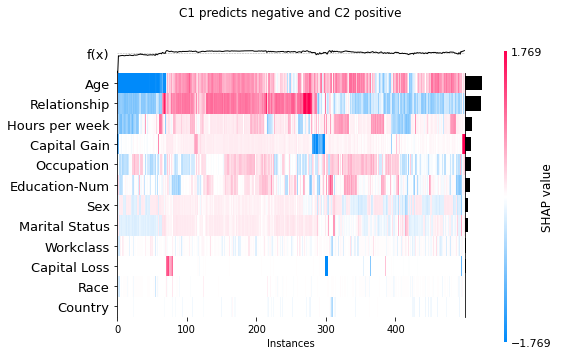

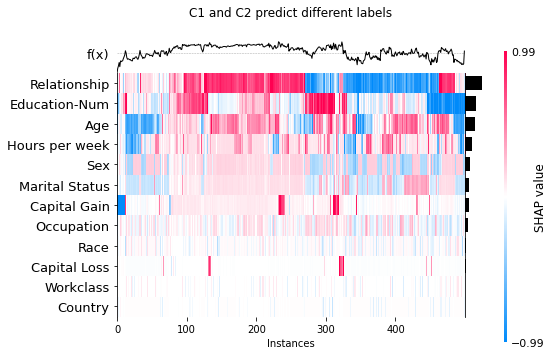

In [29]:
plot_shap_values_hierarchically_clustered(shap_values_f_c1_positive_and_c2_negative, 'C1 predicts positive and C2 negative')
plot_shap_values_hierarchically_clustered(shap_values_f_c1_negative_and_c2_positive, 'C1 predicts negative and C2 positive')
plot_shap_values_hierarchically_clustered(shap_values_f_c1_and_c2_different, 'C1 and C2 predict different labels')

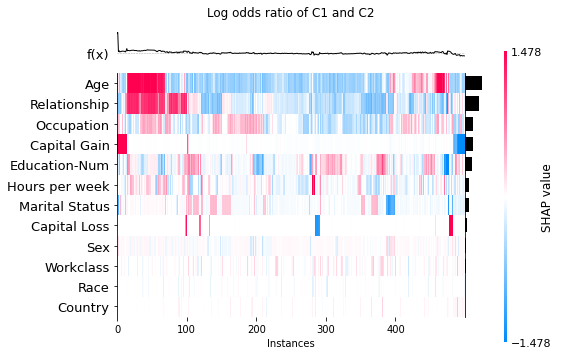

In [30]:
plot_shap_values_hierarchically_clustered(shap_values_f_log_odds_ratio, 'Log odds ratio of C1 and C2')